In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
import json
import lightgbm as lgb
import holidays
import itertools
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import pickle

In [34]:
def generate_oot_folds(df, date_col='date', n_folds=5, test_window=7):
    """
    Gera folds OOT com base na coluna de data, aplicável a todas as séries.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    unique_dates = sorted(df[date_col].unique())

    folds = []
    for i in range(n_folds):
        test_end_idx = len(unique_dates) - i * test_window
        test_start_idx = test_end_idx - test_window
        train_end_idx = test_start_idx

        if train_end_idx <= 0:
            break

        train_dates = unique_dates[:train_end_idx]
        test_dates = unique_dates[test_start_idx:test_end_idx]

        folds.append((train_dates, test_dates))

    return folds


# Read Data
---

In [35]:
df = pd.read_parquet("./sample_trat_curva_A.parquet")

In [36]:
df_valid = pd.read_csv("./valid.csv")

In [37]:
df = pd.concat([
    df.reset_index(drop=True),
    df_valid.query('curva == "A"').drop(columns=['estoque']).reset_index(drop=True)
], ignore_index=True)

In [38]:
# df = df.query('loja_id == 1')

# Processing
---

## changing_names


In [39]:
renames = {
    "loja_id": "merchant_id",
    'produto_id': 'product_id',
    'data': 'date',
    'categoria_id': 'category_id',
    'is_medicamento': 'is_medicine',
    'curva': 'sales_curve',
    'estoque_final': 'ending_stock',
    'venda': 'sales',
    'custo': 'cost',
    'preco': 'price',
    'estoque_inicial': 'starting_stock',
    'estoque_final_anterior': 'previous_ending_stock',
    'reposicao': 'restock',
}

df = df.rename(columns=renames)

## droping columns

In [40]:
to_drop = [
    'ending_stock',
    'starting_stock',
    'previous_ending_stock',
    'restock',
    'sales_curve'
]

df = df.drop(columns=to_drop)

## New Features

## Date 

In [41]:
df['date'] = pd.to_datetime(df['date'])

# Extracting date features
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'] >= 5
df['week_of_year'] = df['date'].dt.isocalendar().week

# Brazilian holidays
br_holidays = holidays.Brazil()
df['is_brazilian_holiday'] = df['date'].isin(br_holidays)

In [42]:
df.head()

,merchant_id,product_id,date,category_id,is_medicine,sales,cost,price,day,month,year,day_of_week,is_weekend,week_of_year,is_brazilian_holiday
0,1,1,2022-01-01,8.0,False,0.0,0.001564,0.003716,1,1,2022,5,True,52,False
1,1,1,2022-01-02,8.0,False,0.0,0.001564,0.003716,2,1,2022,6,True,52,False
2,1,1,2022-01-03,8.0,False,0.0,0.001564,0.003716,3,1,2022,0,False,1,False
3,1,1,2022-01-04,8.0,False,0.0,0.001564,0.003716,4,1,2022,1,False,1,False
4,1,1,2022-01-05,8.0,False,0.0,0.001564,0.003716,5,1,2022,2,False,1,False


## lags

In [43]:
# Criar colunas de semana anterior
df['prev_week'] = df['week_of_year'] - 1
df['prev_year'] = df['year']

# Ajustar quando a semana for 1 (voltar para última semana do ano anterior)
df.loc[df['week_of_year'] == 1, 'prev_week'] = 52  # ou 53 dependendo do calendário, pode ajustar se necessário
df.loc[df['week_of_year'] == 1, 'prev_year'] = df['year'] - 1

# Agrupar para calcular média de cost e price por semana
weekly_avg = df.groupby(
    ['product_id', 'merchant_id', 'year', 'week_of_year']
)[['cost', 'price', 'sales']].mean().reset_index()

# Merge com base na semana anterior
df = df.merge(
    weekly_avg,
    left_on=['product_id', 'merchant_id', 'prev_year', 'prev_week'],
    right_on=['product_id', 'merchant_id', 'year', 'week_of_year'],
    how='left',
    suffixes=('', '_prev_week')
)

# Renomear colunas de média da semana anterior
df.rename(columns={
    'cost_prev_week': 'prev_week_cost_avg',
    'sales_prev_week': 'prev_week_sales_avg',
    'price_prev_week': 'prev_week_price_avg'
}, inplace=True)

# Remover colunas auxiliares
df = df.drop(columns=[
        'year_prev_week', 
        'week_of_year_prev_week', 
        'prev_year', 
        'prev_week'
    ])

df = df.drop(columns=['cost', 'price'])

In [44]:
print(df.shape)
df = df.dropna(subset=['prev_week_cost_avg', 'prev_week_price_avg', 'prev_week_sales_avg'])
print(df.shape)

(1888641, 16)
(1876576, 16)


## Change types

In [45]:
df["date"] = pd.to_datetime(df["date"])

In [46]:
change_types = {
    'category_id': 'int64',
    'is_medicine': 'int64',
    'is_weekend': 'int64',
    'is_brazilian_holiday': 'int64',
}

df = df.astype(change_types)

In [47]:
df.head()

,merchant_id,product_id,date,category_id,is_medicine,sales,day,month,year,day_of_week,is_weekend,week_of_year,is_brazilian_holiday,prev_week_cost_avg,prev_week_price_avg,prev_week_sales_avg
0,1,1,2022-01-01,8,0,0.0,1,1,2022,5,1,52,0,0.001858,0.004830,1.0
1,1,1,2022-01-02,8,0,0.0,2,1,2022,6,1,52,0,0.001858,0.004830,1.0
9,1,1,2022-01-10,8,0,0.0,10,1,2022,0,0,2,0,0.001564,0.003716,0.0
10,1,1,2022-01-11,8,0,0.0,11,1,2022,1,0,2,0,0.001564,0.003716,0.0
11,1,1,2022-01-12,8,0,0.0,12,1,2022,2,0,2,0,0.001564,0.003716,0.0


# Train

In [48]:
# model_params = {
#     'Ridge': {
#         'model': Ridge(),
#         'params': {
#             'alpha': [0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
#         }
#     },
#     'Lasso': {
#         'model': Lasso(),
#         'params': {
#             'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0]
#         }
#     },
#     'DecisionTreeRegressor': {
#         'model': DecisionTreeRegressor(),
#         'params': {
#             'max_depth': [8, 10, 12],                  # Foco na faixa onde encontrou o melhor
#             'min_samples_split': [5, 10, 20],          # Explora menos splits e suavização
#             'min_samples_leaf': [2, 4, 6]              # Mantém folhas um pouco mais robustas
#         }
#     },
#     'RandomForestRegressor': {
#         'model': RandomForestRegressor(),
#         'params': {
#             'n_estimators': [30, 50, 100],
#             'max_depth': [8, 10, 12]
#         }
#     },
#     'XGBRegressor': {
#         'model': xgb.XGBRegressor(),
#         'params': {
#             'n_estimators': [50, 60, 80],               # Foco onde já foi melhor (baixo)
#             'learning_rate': [0.05, 0.1, 0.2],          # Explora um pouco abaixo e acima do ótimo atual
#             'subsample': [0.7, 0.9, 1.0]                # Inclui menos e total (testar impacto)
#         }
#     },
#     'LGBMRegressor': {
#         'model': LGBMRegressor(),
#         'params': {
#             'n_estimators': [125, 150, 175],        # Refina ao redor do 150 (melhor anterior)
#             'learning_rate': [0.15, 0.2, 0.25],     # Foco em torno do ótimo 0.2
#             'num_leaves': [30, 40, 50]              # Mantém a busca centrada em 40
#         }
#     }
# }

In [49]:
model_params = {
    'LGBMRegressor': {
        'model': LGBMRegressor(),
        'params': {
            'n_estimators': [150],
            'learning_rate': [0.20],
            'num_leaves': [40]
        }
    }
}

In [50]:
# 1. Separar a última semana para validação final
max_date = df['date'].max()
val_start = max_date - pd.Timedelta(days=6)

df_val = df[df['date'] >= val_start]
df_train_full = df[df['date'] < val_start]

print(f"Validação final: de {df_val['date'].min().date()} até {df_val['date'].max().date()}")
print(f"Treino + Folds: até {df_train_full['date'].max().date()}")

Validação final: de 2025-02-22 até 2025-02-28
Treino + Folds: até 2025-02-21


In [51]:
folds = generate_oot_folds(df_train_full, date_col='date', n_folds=5, test_window=7)

# Vamos armazenar os conjuntos separados
fold_data = []

for i, (train_dates, test_dates) in enumerate(folds):
    train_df = df_train_full[df_train_full['date'].isin(train_dates)]
    test_df = df_train_full[df_train_full['date'].isin(test_dates)]

    fold_data.append({
        'fold': i + 1,
        'train': train_df,
        'test': test_df
    })

    print(f"Fold {i + 1} -> Treino: {train_df['date'].min().date()} até {train_df['date'].max().date()} | "
          f"Teste: {test_df['date'].min().date()} até {test_df['date'].max().date()}")


Fold 1 -> Treino: 2022-01-01 até 2025-02-14 | Teste: 2025-02-15 até 2025-02-21
Fold 2 -> Treino: 2022-01-01 até 2025-02-07 | Teste: 2025-02-08 até 2025-02-14
Fold 3 -> Treino: 2022-01-01 até 2025-01-31 | Teste: 2025-02-01 até 2025-02-07
Fold 4 -> Treino: 2022-01-01 até 2025-01-24 | Teste: 2025-01-25 até 2025-01-31
Fold 5 -> Treino: 2022-01-01 até 2025-01-17 | Teste: 2025-01-18 até 2025-01-24


In [52]:
# import os

# # Cria a pasta 'models' se ela não existir
# os.makedirs('./models', exist_ok=True)

# model_best_params = {}
# best_preds = 0

# for model_name, config in model_params.items():
#     print(f"Running manual grid search for {model_name}...")

#     model_class = config['model']
#     param_grid = config['params']

#     keys, values = zip(*param_grid.items())
#     param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

#     best_score = float('inf')
#     best_params = None
#     best_model = None

#     for params in tqdm(param_combinations):
#         fold_scores = []

#         for fold in fold_data:
#             train = fold['train']
#             test = fold['test']

#             X_train = train.drop(columns=["date", "sales"])
#             Y_train = train["sales"]
#             X_test = test.drop(columns=["date", "sales"])
#             Y_test = test["sales"]

#             model = model_class.set_params(**params)
#             model.fit(X_train, Y_train)

#             preds = model.predict(X_test)
#             preds = np.maximum(np.round(preds), 0)

#             mae = mean_absolute_error(Y_test, preds)
#             fold_scores.append(mae)
#             # print(mae)

#         mean_mae = np.mean(fold_scores)

#         if mean_mae < best_score:
#             best_score = mean_mae
#             best_params = params
#             best_model = model
#             best_preds = preds

#     print(f'Best Parameters: {best_params}')
#     print(f'Best MAE (mean across folds): {best_score:.6f}\n\n')

#     model_best_params[model_name] = {
#         'model': model_name,
#         'best_param': best_params,
#         'best_score': best_score
#     }

#     with open('model_best_params.json', 'w') as f:
#         json.dump(model_best_params, f, indent=4)

#     with open(f'./models/{model_name}.pkl', 'wb') as f:
#         pickle.dump(best_model, f)

#     del model, best_model, preds


In [53]:
# Separa X e y
X_train = df_train_full.drop(columns=["date", "sales"])
Y_train = df_train_full["sales"]
X_test = df_val.drop(columns=["date", "sales"])
Y_test = df_val["sales"]

# Ajusta modelo final
final_model = LGBMRegressor(n_estimators = 150, learning_rate = 0.20, num_leaves = 40)
final_model.fit(X_train, Y_train)

# Faz predições na validação
val_preds = np.maximum(np.round(final_model.predict(X_test)), 0)

# Avalia desempenho
val_mae = mean_absolute_error(Y_test, val_preds)
print(f"MAE na validação final (última semana): {val_mae:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 1863164, number of used features: 13
[LightGBM] [Info] Start training from score 1.182886
MAE na validação final (última semana): 0.8006


In [54]:
# Cria sub-DataFrame com as colunas desejadas
df_val_preds = df_val[["merchant_id", "product_id", "date", "sales"]].copy()
df_val_preds["predict_sales"] = val_preds

# Salva em CSV
df_val_preds.to_csv("val_preds_A.csv", index=False)

# Exibe as primeiras linhas (opcional)
df_val_preds.head()

,merchant_id,product_id,date,sales,predict_sales
1875229,5,909,2025-02-22,0.0,1.0
1875230,3,909,2025-02-22,3.0,1.0
1875231,10,909,2025-02-22,1.0,1.0
1875232,9,909,2025-02-22,0.0,0.0
1875233,4,909,2025-02-22,1.0,0.0


In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predicted_vs_real(df_train_full, df_val, final_model, merchant_id, product_id):
    # Filtro do histórico
    df_hist = df_train_full.query('merchant_id == @merchant_id and product_id == @product_id').sort_values('date')
    y_hist = df_hist["sales"]

    # Filtro da validação
    df_val_filt = df_val.query('merchant_id == @merchant_id and product_id == @product_id').sort_values('date')
    y_val_real = df_val_filt["sales"]

    # Geração das predições
    X_val_filt = df_val_filt.drop(columns=["date", "sales"])
    y_val_pred = np.round(np.maximum(final_model.predict(X_val_filt), 0))

    # Gráfico
    plt.figure(figsize=(14, 6))
    plt.plot(df_hist["date"], y_hist, label="Histórico (Treino)", marker='o', color = 'blue', linestyle='-')
    plt.plot(df_val_filt["date"], y_val_real, label="Real (Validação)", marker='o', color = 'orange', linestyle='--')
    plt.plot(df_val_filt["date"], y_val_pred, label="Predito (Validação)", marker='x', color = 'green', linestyle='--')

    plt.title(f"merchant_id = {merchant_id} | product_id = {product_id}")
    plt.xlabel("Data")
    plt.ylabel("Vendas")
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_val_real_vs_pred(df_val, final_model, merchant_id, product_id):
    # Filtra a parte de validação
    df_val_filt = df_val.query('merchant_id == @merchant_id and product_id == @product_id').sort_values('date')
    
    # Valores reais
    y_val_real = df_val_filt["sales"]
    
    # Predições
    X_val_filt = df_val_filt.drop(columns=["date", "sales"])
    y_val_pred = np.round(np.maximum(final_model.predict(X_val_filt), 0))
    
    # Gráfico
    plt.figure(figsize=(12, 5))
    plt.plot(df_val_filt["date"], y_val_real, label="Real", marker='o', color = 'orange', linestyle='-')
    plt.plot(df_val_filt["date"], y_val_pred, label="Predito", marker='x', color = 'green', linestyle='--')
    
    plt.title(f"Validação — merchant_id = {merchant_id} | product_id = {product_id}")
    plt.xlabel("Data")
    plt.ylabel("Vendas")
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


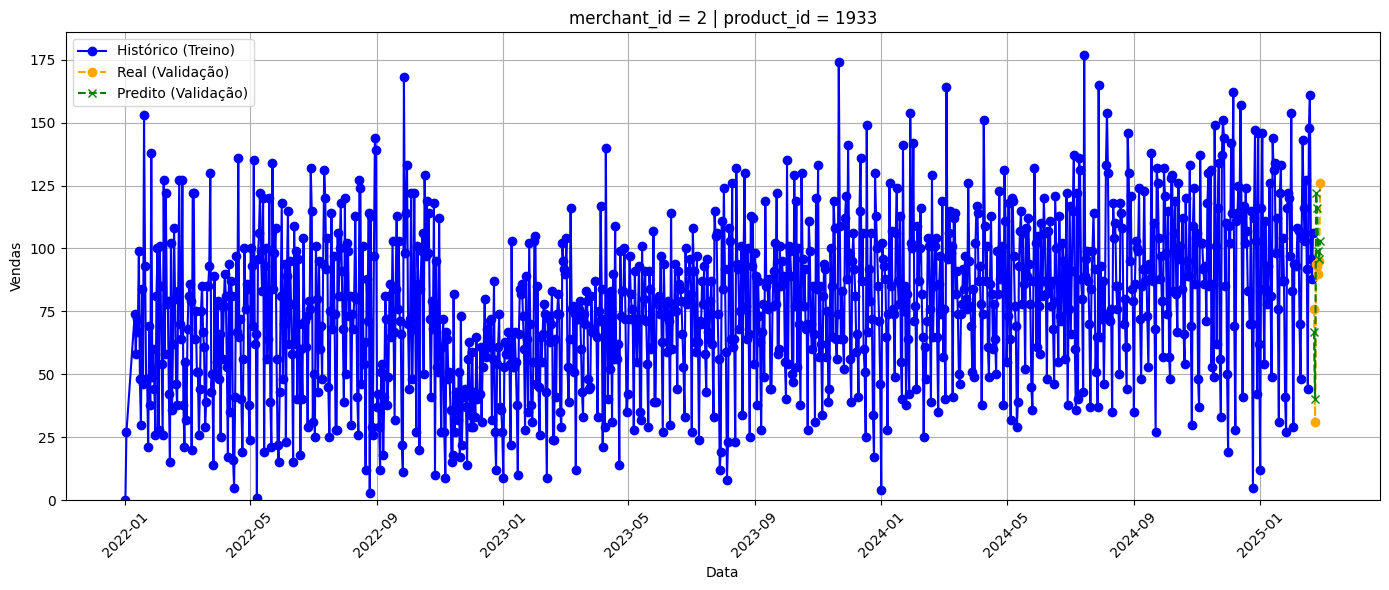

In [57]:
plot_predicted_vs_real(df_train_full, df_val, final_model, merchant_id=2, product_id=1933)

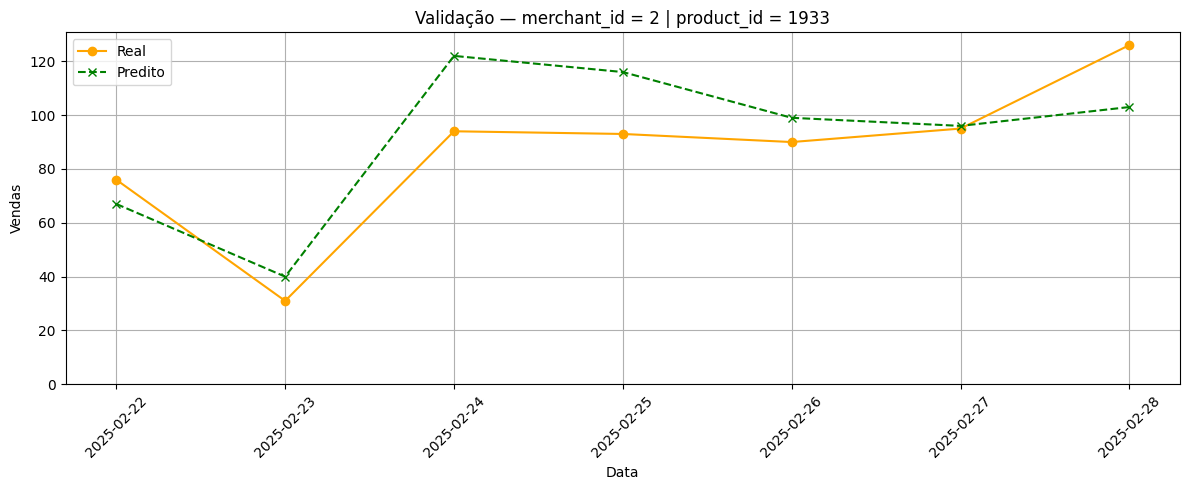

In [58]:
plot_val_real_vs_pred(df_val, final_model, merchant_id=2, product_id=1933)